## Questions:

Cells were recorded in up to 4 sessions.

### What percentage of cells is present across multiple sessions?

[all 4? 3? 2?]

### For cells present on 2/3 days, is there any patterning of the days that cells are present?

* Random?
* Cells only present during training or reversal?
* Cells only present during less (Session 2 & 7) or more (Session 6 & 9) reward certainty?

### Are these percentages/patterns affected by the drug treatment?

In [20]:
import os 
import pandas as pd
import numpy as np
from itertools import combinations, product
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix 
from lib import *

sessions = [2, 6, 7, 9]
str_sessions = [str(x) for x in sessions]
events = ['ReSpout_pos', 'ReSpout_neg', \
       'UnSpout_pos', 'UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', \
       'UnMid_neg']
       
fn_in = './data/input/explore2.csv'
df = pd.read_csv(fn_in)
conditions = df.treatment.unique()
n_cond = len(conditions)
n_animals = 3

In [110]:
conditions

array(['Control', 'Clonidine', 'Idazoxan'], dtype=object)

Number of cells by recording day

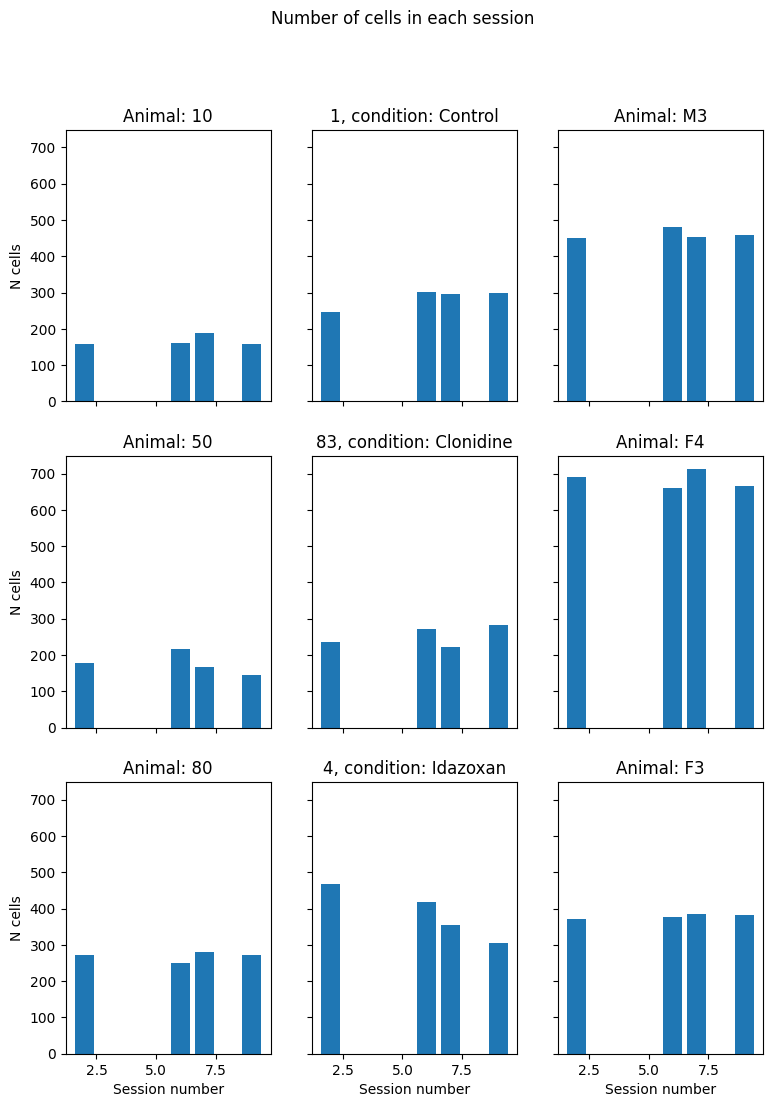

In [21]:
counts_by_day = np.zeros((n_cond, n_animals, len(sessions))) # #conditions, #animals, #days 

for i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for j, animal in enumerate(animals):
        counts_by_day[i,j] = np.sum(np.stack(list(cell_stats[animal].values())), axis = 0)
        
fig, axes = plt.subplots(n_cond, n_animals, figsize = (9,12), sharex = True, sharey = True)
for i,j in product(range(n_cond), range(n_animals)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])
    axes[i,j].bar(sessions, counts_by_day[i,j], label = str_sessions)
    if j == 0:
        axes[i,j].set_ylabel('N cells')
    title = f'Animal: {animals[j]}'
    if j == 1:
        title += f', condition: {conditions[i]}'
        title = title.replace('Animal: ', '')
    axes[i,j].set_title(title)
    if i == 2:
        axes[i,j].set_xlabel('Session number')
fig.suptitle("Number of cells in each session");

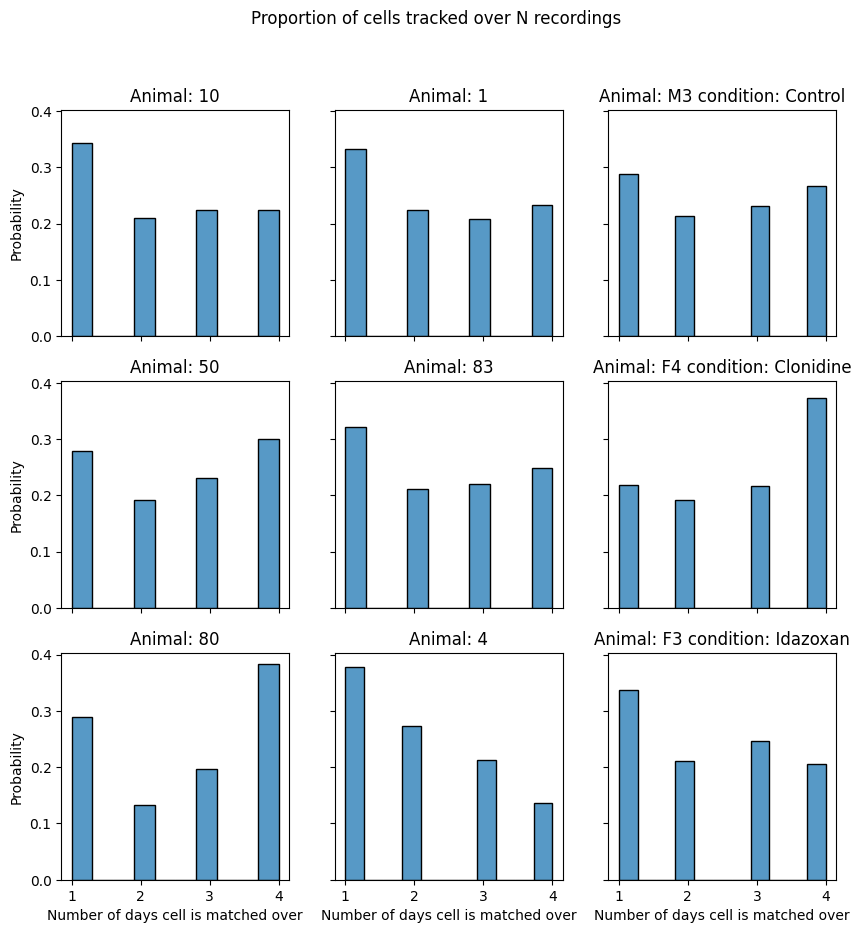

In [18]:
fig, axes = plt.subplots(n_cond, n_animals, figsize = (10, 10), sharex = True, sharey = True)

for c_idx in range(n_cond):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[c_idx])
    for idx in range(n_animals):
        sns.histplot(cell_sums_list[animals[idx]], ax = axes[c_idx,idx], stat = 'probability')
        axes[c_idx,idx].set_title(f'Animal: {animals[idx]}')

    axes[c_idx, idx].set_title(f'Animal: {animals[idx]} condition: {conditions[c_idx]}')

for idx in range(n_animals):
    axes[2,idx].set_xlabel("Number of days cell is matched over")

fig.suptitle("Proportion of cells tracked over N recordings");

Pooling animals together:

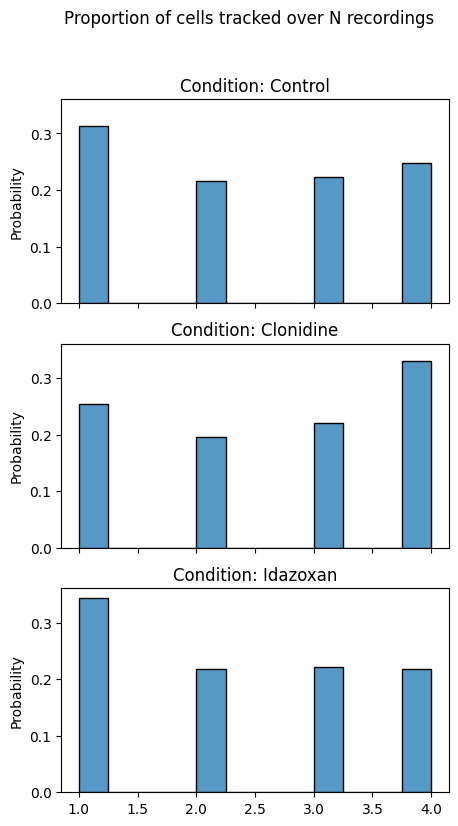

In [22]:
fig, axes = plt.subplots(n_cond, 1, figsize = (5, 9), sharex = True, sharey = True)
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[0])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]] + cell_sums_list[animals[2]]
sns.histplot(csl, ax = axes[0], stat = 'probability')
axes[0].set_title(f'Condition: {conditions[0]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[1])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]] + cell_sums_list[animals[2]]
sns.histplot(csl, ax = axes[1], stat = 'probability')
axes[1].set_title(f'Condition: {conditions[1]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[2])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]] + cell_sums_list[animals[2]]
sns.histplot(csl, ax = axes[2], stat = 'probability')
axes[2].set_title(f'Condition: {conditions[2]}')
fig.suptitle("Proportion of cells tracked over N recordings");

Are these counts significantly different?

In [23]:
#Form contingency tables
contingencies = np.zeros((3,4))
for idx in range(3):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[idx])
    csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]] + cell_sums_list[animals[2]]
    csl_counts = Counter(csl)
    csl_counts_ = [csl_counts[k] for k in range(1,5)]
    contingencies[idx,:] = csl_counts_
    
# Two-sample chi-square test
for i,j in combinations(range(3), 2):
    result = chi2_contingency(contingencies[[i,j],:])
    print(f'Chi2 test {conditions[i]} vs {conditions[j]}: {result[1]}')

Chi2 test Control vs Clonidine: 1.4344609613076383e-06
Chi2 test Control vs Idazoxan: 0.12537422750773983
Chi2 test Clonidine vs Idazoxan: 3.227021322977977e-14


*Not* significantly different.

How many cells are matched, at all, per session?

/home/blansdel/anaconda3/envs/ethome/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3382: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_2967278/1519772614.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(sessions)


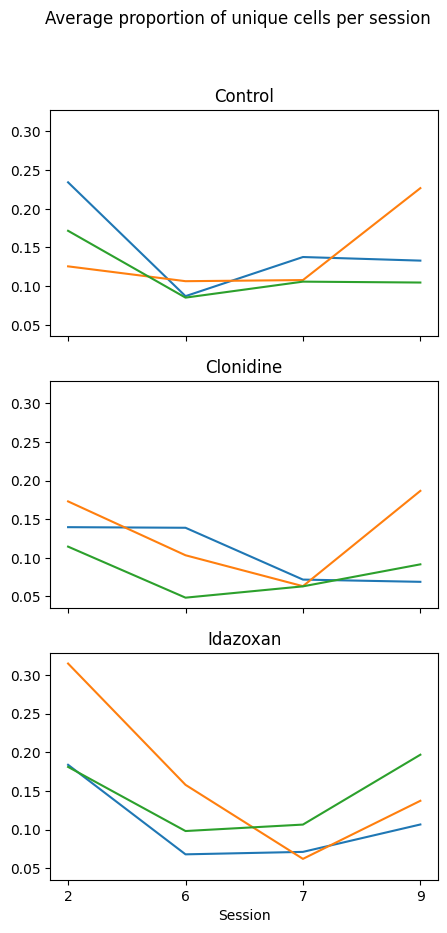

In [24]:
prop_unique_cells = np.zeros((n_cond,n_animals,4))
for i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for j, animal in enumerate(animals): 
        animal_stats = np.stack(cell_stats[animal].values())
        for idx in range(len(sessions)):
            present_cells = animal_stats[:,idx] == 1
            non_idx = list(range(4))
            non_idx.remove(idx)
            unique_cells = animal_stats[:,non_idx].sum(axis = 1) == 0    
            n_unique_cells = sum(unique_cells)
            n_cells = sum(present_cells)
            prop_unique_cells[i,j,idx] = n_unique_cells/n_cells

fig, axes = plt.subplots(n_cond,1,figsize = (5,10), sharex = True, sharey = True)
for i in range(n_cond):
    axes[i].plot(range(1,5), prop_unique_cells[i,:,:].T)
    axes[i].set_xticklabels(sessions)
    axes[i].set_xticks(range(1,5))
    if i == 2:
        axes[i].set_xlabel('Session')
    axes[i].set_title(conditions[i])
fig.suptitle('Average proportion of unique cells per session');

Now, for each pair or recordings, what proportion of cells are matched between the recs?

/home/blansdel/anaconda3/envs/ethome/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3382: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


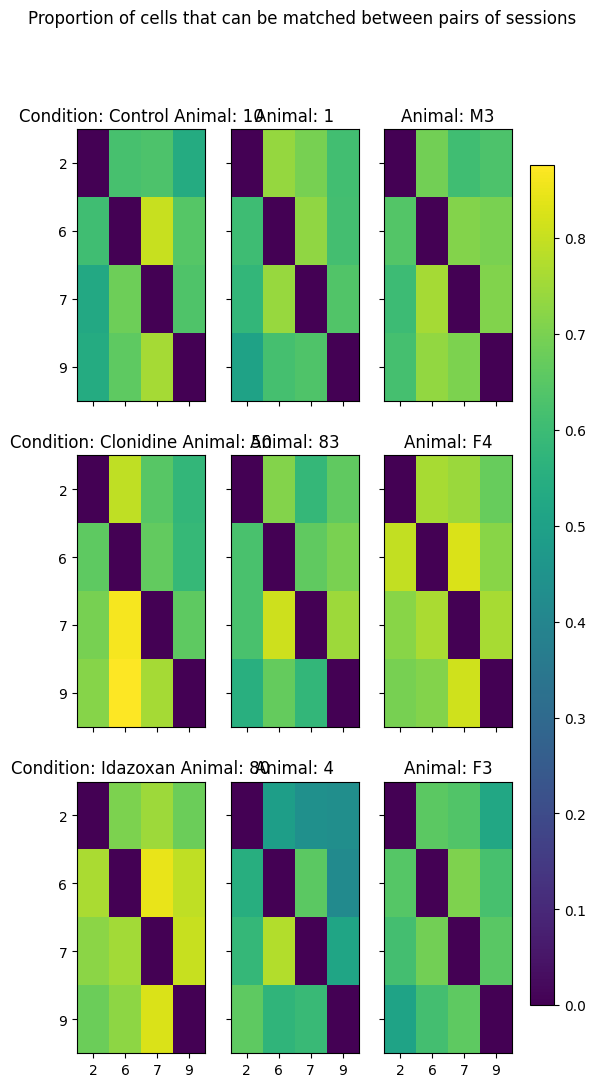

In [25]:
matching_matrix = np.zeros((n_cond, n_animals, 4, 4))

for c_i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for a_j, animal in enumerate(animals):
        animal_stats = np.stack(cell_stats[animal].values())

        #Of all cells present in s1, how many are present in s2?
        for s1, s2 in product(range(4), range(4)):
            if s1 == s2:
                matching_matrix[c_i, a_j, s1, s2] = 0
                continue
            a_stats = animal_stats[animal_stats[:,s1] == 1, s2]
            matching_matrix[c_i, a_j, s1, s2] = a_stats.sum()/a_stats.shape[0]
            
# find minimum of minima & maximum of maxima
minmin = np.min(matching_matrix)
maxmax = np.max(matching_matrix)

fig, axes = plt.subplots(n_cond, n_animals, figsize = (6,12), sharex = True, sharey = True)
for i,j in product(range(n_cond), range(n_animals)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])

    ims = axes[i,j].imshow(matching_matrix[i,j,:,:], vmin = minmin, vmax = maxmax, aspect = 'auto')
    axes[i,j].set_xticks(range(4))
    axes[i,j].set_xticklabels(sessions)
    axes[i,j].set_yticks(range(4))
    axes[i,j].set_yticklabels(sessions)
    title = f'Animal: {animals[j]}'
    if j == 0:
        title = f'Condition: {conditions[i]} ' + title
    axes[i,j].set_title(title)
fig.suptitle("Proportion of cells that can be matched between pairs of sessions");
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(ims, cax=cbar_ax);

In [26]:
#Plot mean proportion as a function of days from the recording
#Take mean over animals
mean_matching_matrix = np.mean(matching_matrix, axis = 1)

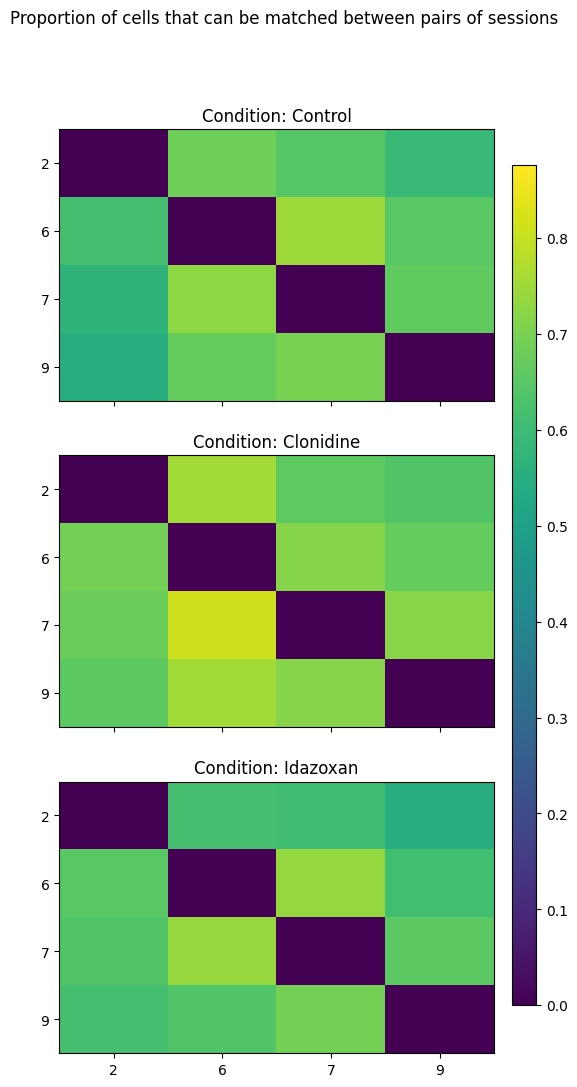

In [27]:
fig, axes = plt.subplots(3,1, figsize = (6,12), sharex = True, sharey = True)
for i in product(range(3)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])
    ims = axes[i].imshow(mean_matching_matrix[i,:,:].squeeze(), vmin = minmin, vmax = maxmax, aspect = 'auto')
    axes[i].set_xticks(range(4))
    axes[i].set_xticklabels(sessions)
    axes[i].set_yticks(range(4))
    axes[i].set_yticklabels(sessions)
    title = f'Condition: {conditions[i]}'
    axes[i].set_title(title)
fig.suptitle("Proportion of cells that can be matched between pairs of sessions");
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(ims, cax=cbar_ax);

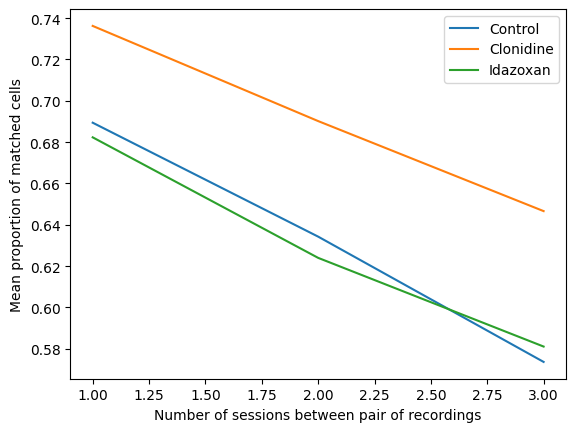

In [28]:
prop_n_from_rec = np.zeros((n_cond,n_cond))
n_from_rec = np.zeros((n_cond,n_cond))
for idx, cond in enumerate(conditions):
    for i,j in product(range(4), range(4)):
        if i == j: continue
        diff = abs(i-j)
        prop_n_from_rec[idx, diff-1] += mean_matching_matrix[idx, i, j]
        n_from_rec[idx,diff-1] += 1
mean_prop_n_from_rec = prop_n_from_rec/n_from_rec

plt.plot([1,2,3], mean_prop_n_from_rec.T)
plt.ylabel("Mean proportion of matched cells")
plt.xlabel("Number of sessions between pair of recordings");
plt.legend(conditions);

Can you match more cells in training? Or in reversal?

### Increases activity as a result of more training

* Find cells that respond *more* strongly at reward spout with *more* training
* Do these cells show the same behavior during retraining?
* Plot correlation matrix of cell response profiles 

In [219]:
animal = '10'
treatment = 'Control'
df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, treatment)
cell_fully_tracked = [k for k,v in cell_stats[animal].items() if np.sum(v) == 4]
print("cells tracked throughout 4 recordings", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))

cells tracked throughout 4 recordings 64 out of 286


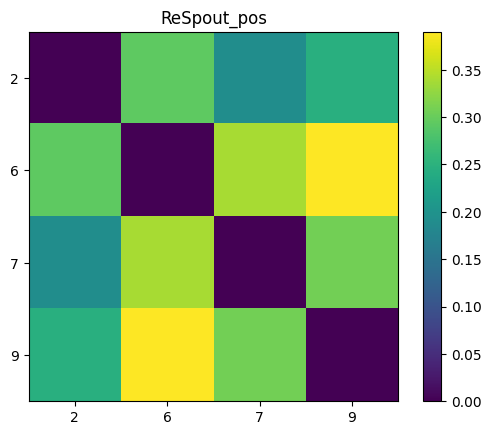

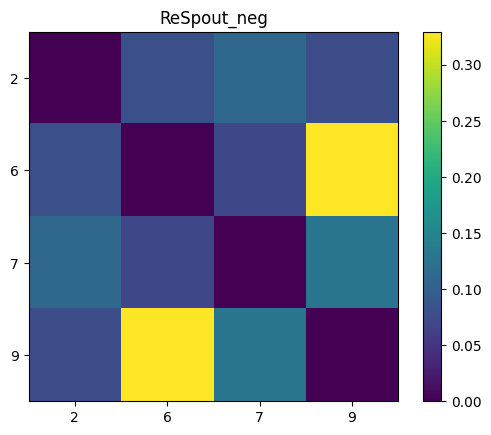

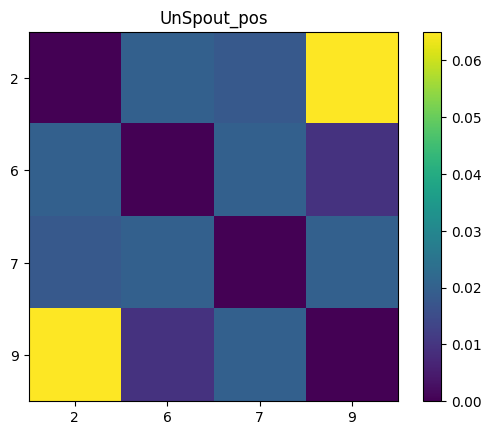

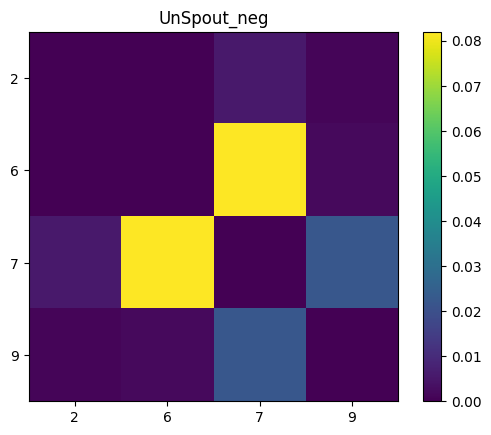

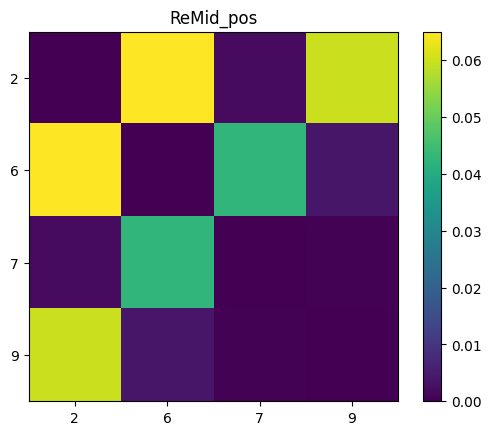

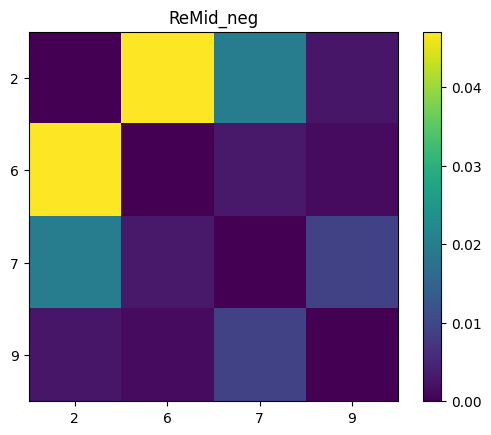

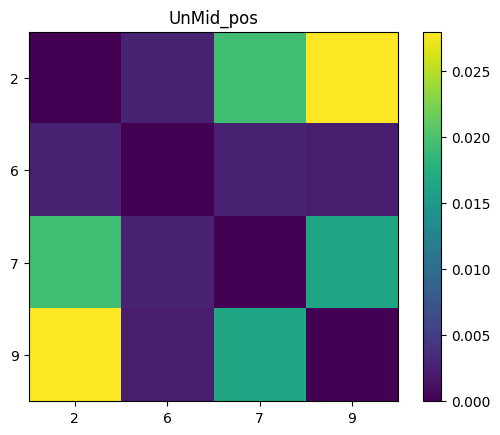

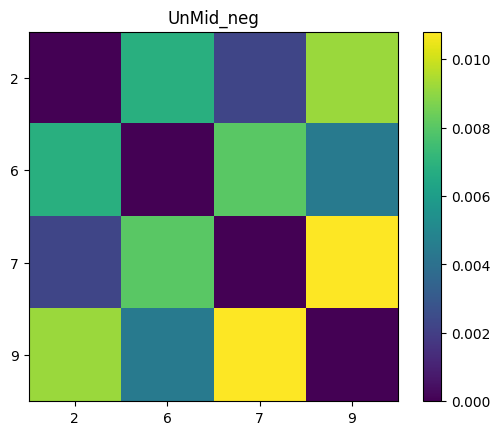

In [220]:
for event in events:
    mis = np.zeros((4,4))
    for i, s_1 in enumerate(sessions):
        for j, s_2 in enumerate(sessions):
            if s_1 == s_2: continue 
            ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
            ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
            ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
            ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
            ds = pd.merge(ds1, ds2, on = 'MatchID')
            mi = mutual_info(ds[f'{event}_x'], ds[f'{event}_y'])
            mis[i,j] = mi
    fig, axes = plt.subplots(1,1)
    plt.imshow(mis)
    plt.title(event)
    plt.colorbar()
    plt.xticks(range(4), labels = sessions)
    plt.yticks(range(4), labels = sessions)

Instead try matching all cells we can between the two sessions...

In [221]:
animal = '10'
treatment = 'Control'
df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, treatment)
cell_fully_tracked = [k for k,v in cell_stats[animal].items() if np.sum(v) == 4]
print("cells tracked throughout 4 recordings", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))

cells tracked throughout 4 recordings 64 out of 286


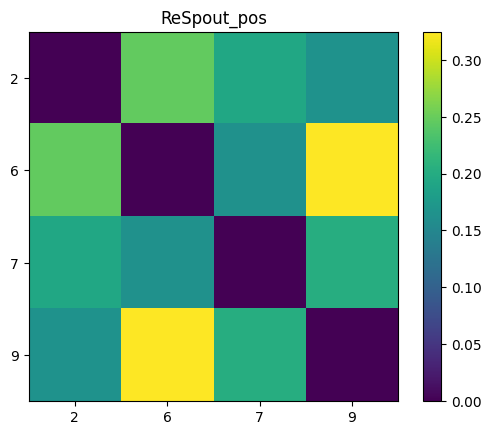

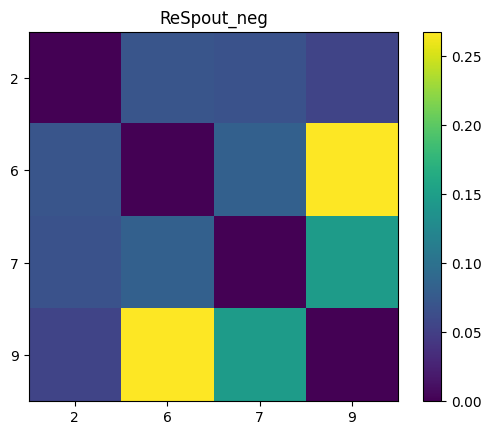

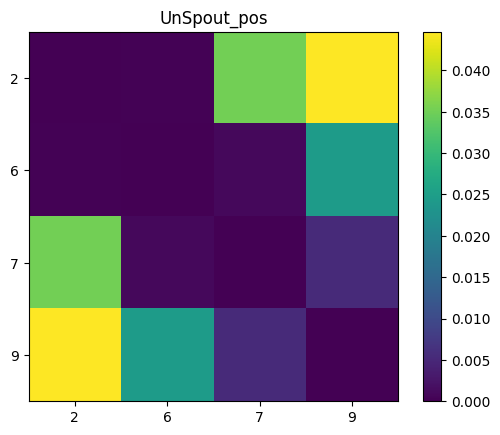

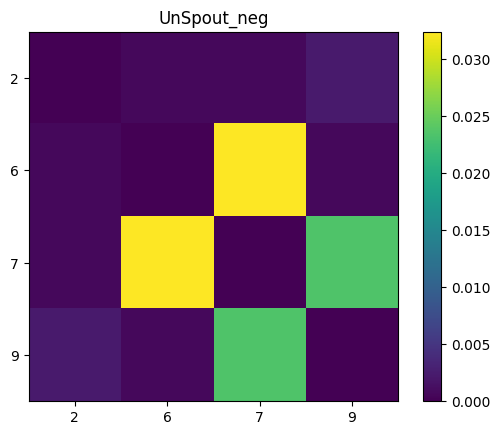

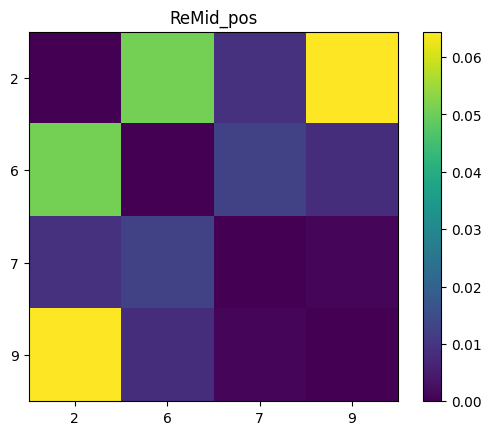

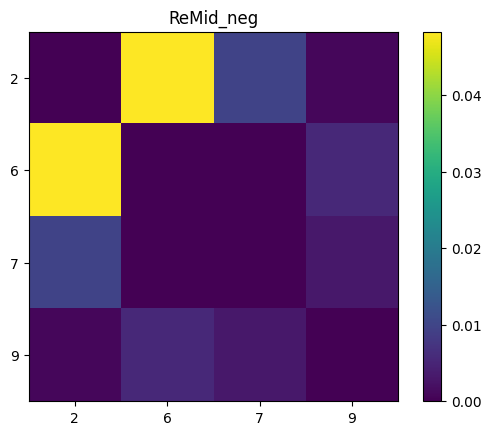

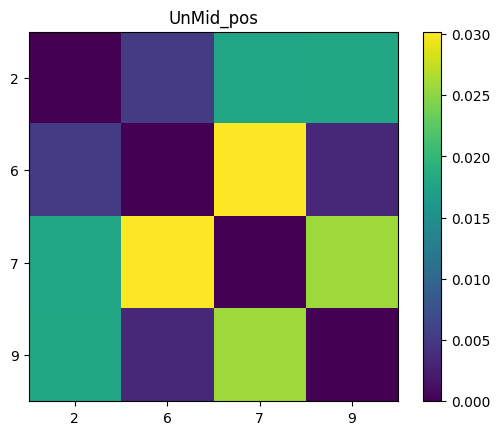

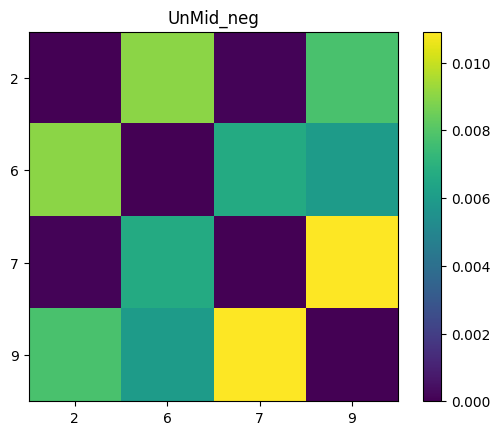

In [222]:
for event in events:
    mis = np.zeros((4,4))
    for i, s_1 in enumerate(sessions):
        for j, s_2 in enumerate(sessions):
            if s_1 == s_2: continue 
            cell_fully_tracked = [k for k,v in cell_stats[animal].items() if (v[i] == 1 and v[j] == 1)]
            ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
            ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
            ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
            ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
            ds = pd.merge(ds1, ds2, on = 'MatchID')
            mi = mutual_info(ds[f'{event}_x'], ds[f'{event}_y'])
            mis[i,j] = mi
    fig, axes = plt.subplots(1,1)
    plt.imshow(mis)
    plt.title(event)
    plt.colorbar()
    plt.xticks(range(4), labels = sessions)
    plt.yticks(range(4), labels = sessions)

### Find 'value' cells

Cells that increase the responsiveness to training. E.g. compare days 2-6 and 7-9.


In [223]:
animal = '10'
treatment = 'Control'
df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, treatment)
cell_fully_tracked = [k for k,v in cell_stats[animal].items() if np.sum(v) == 4]
print("cells tracked throughout 4 recordings", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))

cells tracked throughout 4 recordings 64 out of 286


In [224]:
#Identify cells that increase between 2-6
cell_fully_tracked = [k for k,v in cell_stats[animal].items() if (np.sum(v) == 4)]

s_1 = 2; s_2 = 6
ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
ds = pd.merge(ds1, ds2, on = 'MatchID')

ds['increases_resp'] = (ds['ReSpout_y'] > ds['ReSpout_x'])# & ds['ReSpout_pos_y']

s_1 = 7; s_2 = 9
ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
ds_post = pd.merge(ds1, ds2, on = 'MatchID')

ds_post['increases_resp'] = (ds_post['ReSpout_y'] > ds_post['ReSpout_x'])# & ds_post['ReSpout_pos_y']
ds_inc = pd.merge(ds, ds_post, on = 'MatchID')
confusion_matrix(ds_inc['increases_resp_x'], ds_inc['increases_resp_y'])

array([[19, 13],
       [17, 15]])

### Null-distribution for number of cell categories

Here we:
* Assume responsiveness only occurs by chance (alpha = 0.05)
* Assign cells randomly to be responsive or not to given condition
* Categorize into classes
* Do this a number of times
* Compute p-values for classification of cell
* How many cells do we expect to be classified as 'rewarded' by chance alone?

In [226]:
df

,recording,Animal,Session,Reward,CellID,MatchID,ReSpout,UnSpout,ReMid,UnMid,...,ReSpout_pos,ReSpout_neg,UnSpout_pos,UnSpout_neg,ReMid_pos,ReMid_neg,UnMid_pos,UnMid_neg,treatment,CellType
0,final_100202.Rds,10,2,right,1,1,0.473993,0.407851,0.532243,0.695288,...,False,False,False,False,False,False,False,False,Control,Non-responsive
1,final_100202.Rds,10,2,right,10,10,0.509094,0.568929,0.495908,0.445092,...,False,False,False,False,False,False,False,False,Control,Non-responsive
2,final_100202.Rds,10,2,right,100,100,0.805992,0.545977,0.384378,0.393388,...,True,False,False,False,False,False,False,False,Control,Rewarded
3,final_100202.Rds,10,2,right,101,101,0.204421,0.325180,0.469198,0.645885,...,False,True,False,True,False,False,False,False,Control,Non-discriminatory
4,final_100202.Rds,10,2,right,102,102,0.665561,0.636526,0.387639,0.356322,...,True,False,True,False,False,False,False,False,Control,Non-discriminatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12232,final_M30823.Rds,M3,9,right,95,486,0.188378,0.494002,0.447319,0.432660,...,False,True,False,False,False,False,False,False,Control,Rewarded
12233,final_M30823.Rds,M3,9,right,96,88,0.821319,0.336226,0.613533,0.317057,...,True,False,False,False,False,False,False,False,Control,Rewarded
12234,final_M30823.Rds,M3,9,right,97,485,0.229063,0.555749,0.488575,0.339313,...,False,True,False,False,False,False,False,False,Control,Rewarded
12235,final_M30823.Rds,M3,9,right,98,85,0.836697,0.656634,0.373275,0.343116,...,True,False,False,False,False,False,False,False,Control,Rewarded


In [192]:
def classify_cell(df, idx):
    row = df.iloc[idx]
    tp = 'Non-responsive'
    if ((row.ReSpout_pos == True) or (row.ReSpout_neg == True) or (row.ReMid_pos == True) or (row.ReMid_neg == True)) and \
        ((row.UnSpout_pos == False) or (row.UnSpout_neg == False) or (row.UnMid_pos == False) or (row.UnMid_neg == False)):
        tp = 'Rewarded'
    if ((row.UnSpout_pos == True) or (row.UnSpout_neg == True) or (row.UnMid_pos == True) or (row.UnMid_neg == True)) and \
        ((row.ReSpout_pos == False) or (row.ReSpout_neg == False) or (row.ReMid_pos == False) or (row.ReMid_neg == False)):
        tp = 'UnRewarded'

    return tp

In [ ]:
stats = df.groupby(['treatment', 'Animal', 'Session', 'CellType']).count()['recording']
stats = stats.reset_index()
treatments = conditions
for treat in treatments:
    animals = stats.loc[stats.treatment == treat, "Animal"].unique()
    for animal in animals:
        for session in sessions:
            this_cell_sum = stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "recording"].sum()
            stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "cell_prob"] = \
                stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "recording"]/this_cell_sum

In [212]:
alpha = 0.05
df_null = df.copy()
N_reps = 100

# non_responsive_props = defaultdict(dict)
# rewarded_props = defaultdict(dict)
# unrewarded_props = defaultdict(dict)
sample_cols = ['ReSpout_pos','ReSpout_neg','UnSpout_pos','UnSpout_neg',	'ReMid_pos', 'ReMid_neg', 'UnMid_pos', 'UnMid_neg']

resampling_results = pd.DataFrame(columns = ['treatment', 'animal', 'session', 'celltype', 'p-val'])

for treat in conditions:
    animals = df_null.loc[df_null.treatment == treat, "Animal"].unique()
    for animal in animals:
        for session in sessions:
            df_null_cond = df_null.loc[(df_null['treatment'] == treat) & (df_null['Animal'] == animal) & (df_null['Session'] == session)]
            nr = []
            rr = []
            ur = []
            for rep in range(N_reps):
                df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
                for idx in range(len(df_null_cond)):
                    ct = classify_cell(df_null_cond, idx)
                    df_null_cond.iloc[idx,-1] = ct
                cts = df_null_cond.CellType.value_counts()/len(df_null_cond)
                nr.append(cts['Non-responsive'])
                rr.append(cts['Rewarded'])
                ur.append(cts['UnRewarded'])
            try:
                p_nr = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Non-responsive'), 'cell_prob'].values[0]
                p_rr = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Rewarded'), 'cell_prob'].values[0]
                p_ur = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Unrewarded'), 'cell_prob'].values[0]
            except IndexError: 
                print("Skipping", treat, animal, session)
                continue
            pval_nr = sum(p_nr < np.array(nr))/N_reps
            pval_ur = sum(p_ur < np.array(ur))/N_reps
            pval_rr = sum(p_rr < np.array(rr))/N_reps
            newrow1 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['Non-responsive'], 'p-val': [pval_nr]})
            newrow2 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['Rewarded'], 'p-val': [pval_rr]})
            newrow3 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['UnRewarded'], 'p-val': [pval_ur]})
            resampling_results = pd.concat([resampling_results, newrow1, newrow2, newrow3], axis = 0)




/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_2967278/2712826441.py:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Skipping Clonidine 83 6


/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Skipping Idazoxan 4 6


/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_2967278/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

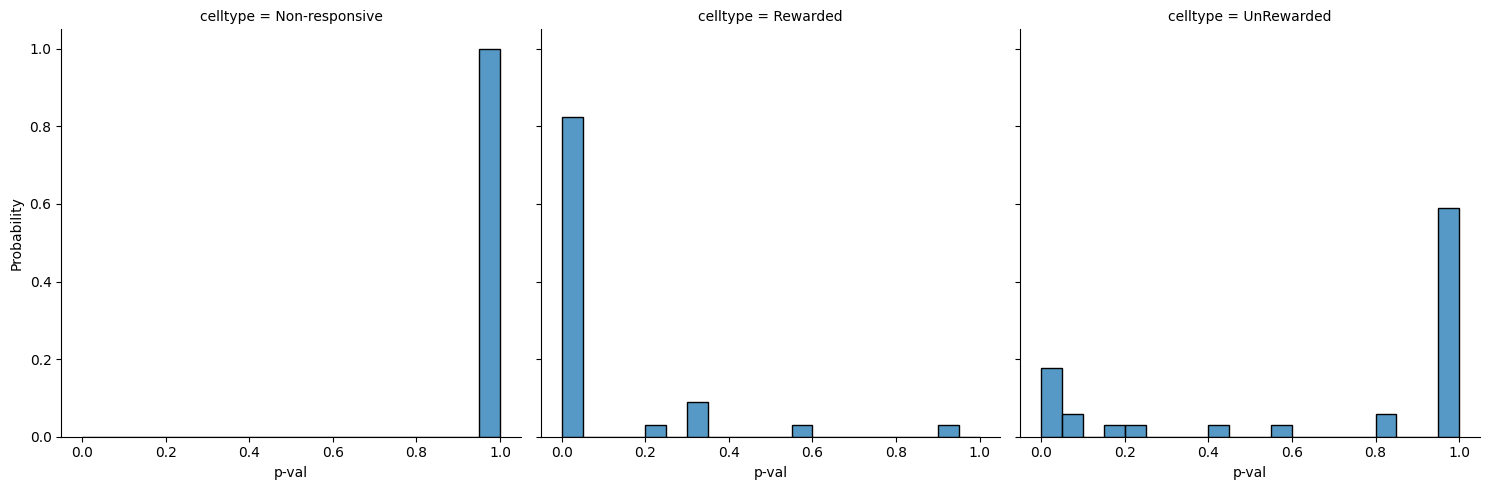

In [218]:
sns.displot(resampling_results, x = 'p-val', col = 'celltype', bins = 20, stat = 'probability', common_norm = False)

Observed, many *more* rewarded cells than expected based on alpha level. Not the same overabundance in unrewarded cells. Gives a way to interpret the number of responsive cells as high or not.

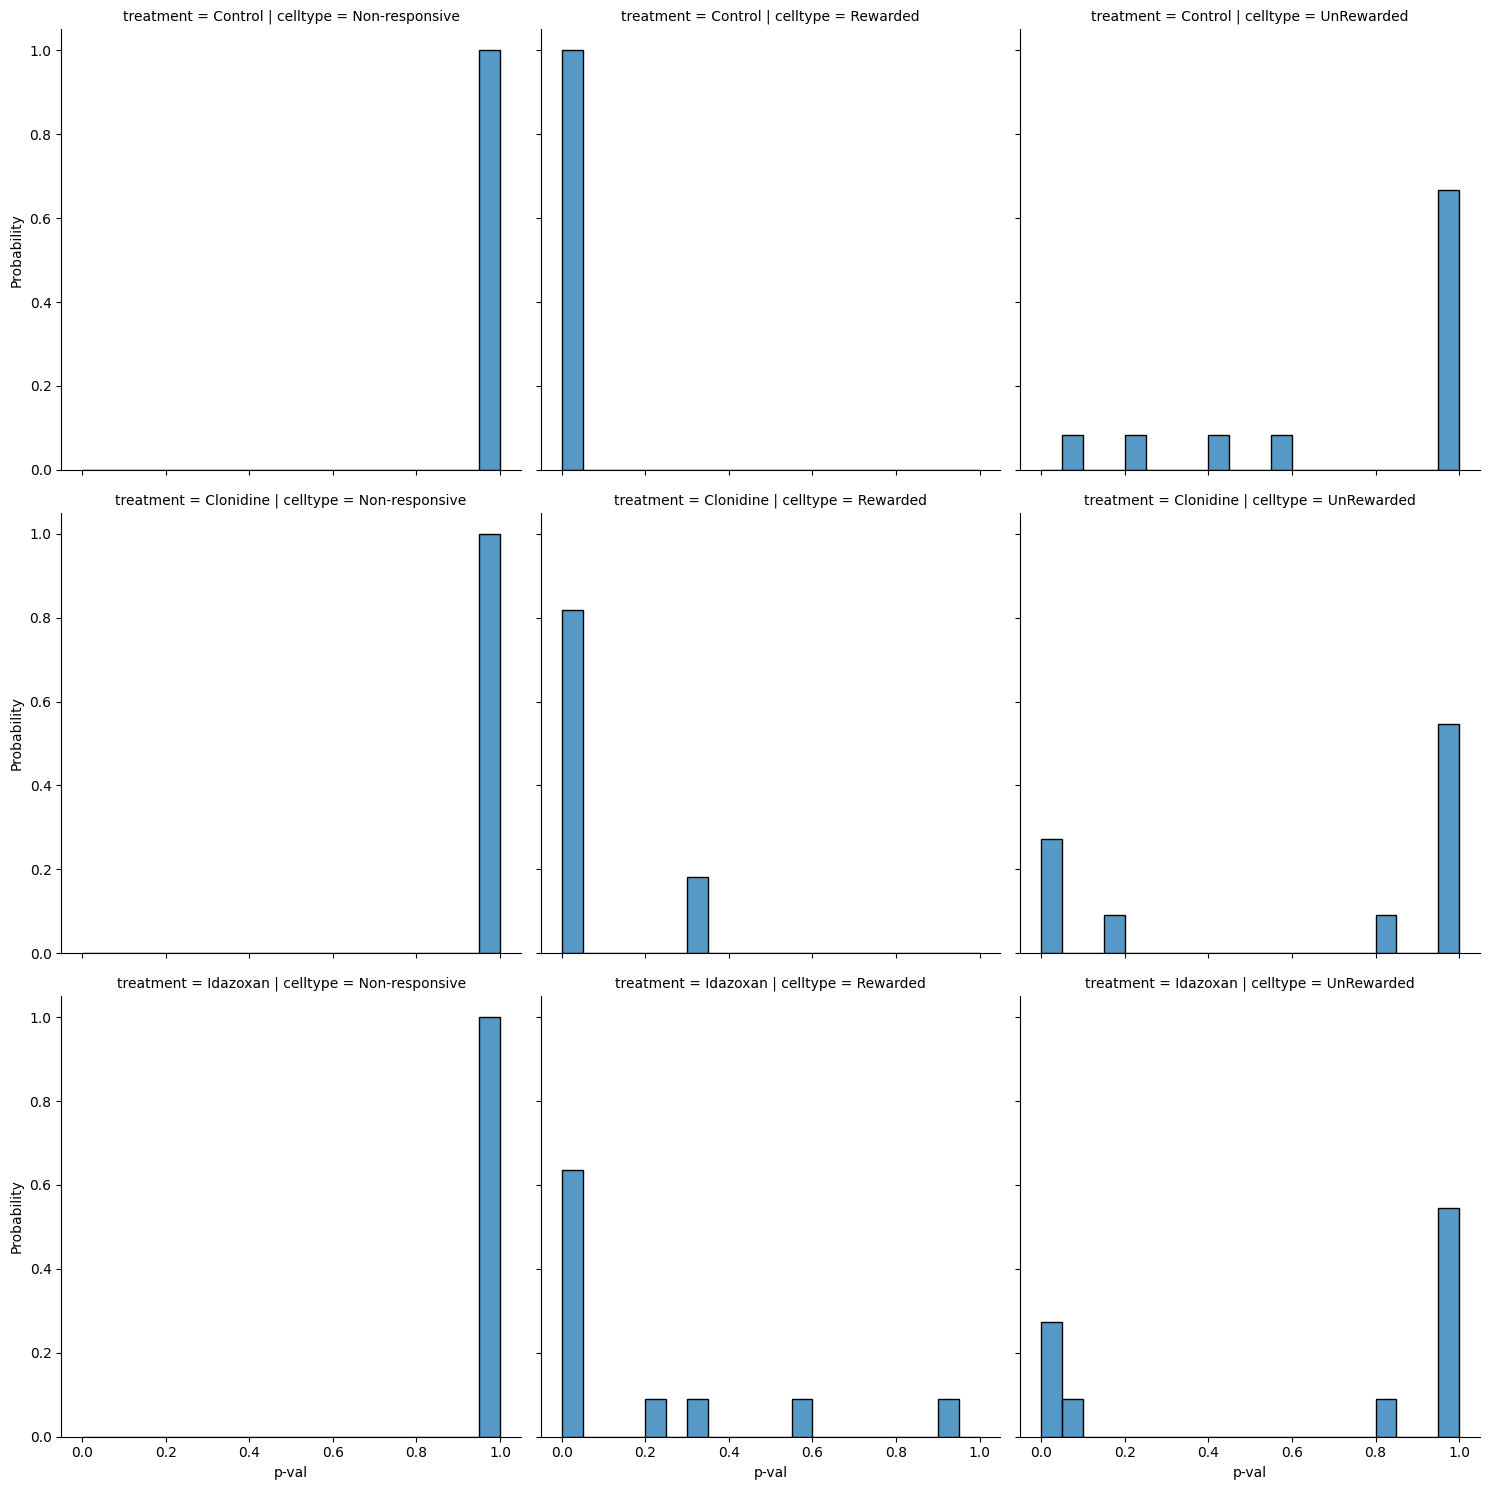

In [225]:
sns.displot(resampling_results, x = 'p-val', col = 'celltype', row = 'treatment', bins = 20, stat = 'probability', common_norm = False)

In [166]:
#Cell types:
# Non-responsive -- no responses
# Unrewarded -- only unrewarded
# Rewarded -- only rewarded
# Non-discriminatory -- both rewarded and unrewarded
# Inverse -- positive reward, negative unreward

# ['ReSpout_pos','ReSpout_neg','UnSpout_pos','UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', 'UnMid_neg']
#   x             x             x             x              x            x            x            x
#                               1             1                                        1            1 
#   1             1                                          1            1     
#   1             1             1             1              1            1            1            1 
#




Baseline probabilities or two cell types, expected purely by simple definition

Expected counts for non-responsive
`(1-alpha)^8`

Expected counts for rewarded:
`1-(1-alpha)^4`

Expected counts for unrewarded:
`1-(1-alpha)^4`

In [168]:
non_responsive_prob = (1-alpha)**8
rewarded_prob = 1-(1-alpha)**4

In [169]:
rewarded_prob

0.18549375000000012